In [194]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [195]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor

## Implementando o modelo de ML com LinearRegression

### Coleta de dados
 - Utilizando a lib **yFinance** para extracao de dados de cotacoes do dia 01/01/2015 a 31/07/2024
 - Download de dados historicos

In [196]:
warnings.filterwarnings('ignore')

tickers = ['AAPL', 'MSFT', 'PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 
           'BBAS3.SA', 'ABEV3.SA', 'B3SA3.SA', 'WEGE3.SA', 'RENT3.SA', 
           'JBSS3.SA', 'MGLU3.SA', 'BRFS3.SA', 'SUZB3.SA', 'ELET3.SA']

start_date = '2015-01-01'
end_date = '2024-07-31'

In [197]:
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Preparacao dos dados
- Calculo de metricas como volatilidade, data, media movel de 5 dias. Estas metricas sao usadas como Features no treinamento do modelo. 

In [198]:
def prepare_data(df):
    df['Date'] = df.index
    df['Return'] = df['Close'].pct_change()
    df['Moving_Average'] = df['Close'].rolling(window=5).mean()
    df['Volatility'] = df['Return'].rolling(window=5).std()
    df.dropna(inplace=True)
    return df[['Date', 'Close', 'Moving_Average', 'Volatility']]

In [199]:
prepared_data = {}
for ticker in tickers:
    prepared_data[ticker] = prepare_data(data[ticker])


### Treinamento do modelo 
- Separando os dados em 80% para treino e 20% para teste
- Modelo foi ajustado para prever o preco de fechamentro das acoes com base nas features calculadas.
- Avaliacao do modelo com metricas de MSE e MAE para medir a precisao do modelo


In [200]:
# Treinamento e teste para previsão
def train_and_predict(df, ticker):
    X = df[['Moving_Average', 'Volatility']]
    y = df['Close']

    # Divisão dos dados
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modelo de Regressão Linear
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Previsão
    y_pred = model.predict(X_test)

    # Avaliação
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Modelo para {ticker}:')
    print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')

    return model

- Treinamento e previsao das acoes da Apple e Microsoft utilizando a funcao **train_and_predict**

In [202]:
models = {}
for ticker in tickers:
    models[ticker] = train_and_predict(prepared_data[ticker], ticker)

Modelo para AAPL:
MSE: 3.98, MAE: 1.29
Modelo para MSFT:
MSE: 11.35, MAE: 2.19
Modelo para PETR4.SA:
MSE: 0.55, MAE: 0.50
Modelo para VALE3.SA:
MSE: 1.94, MAE: 0.98
Modelo para ITUB4.SA:
MSE: 0.34, MAE: 0.43
Modelo para BBDC4.SA:
MSE: 0.19, MAE: 0.32
Modelo para BBAS3.SA:
MSE: 0.25, MAE: 0.35
Modelo para ABEV3.SA:
MSE: 0.09, MAE: 0.22
Modelo para B3SA3.SA:
MSE: 0.11, MAE: 0.21
Modelo para WEGE3.SA:
MSE: 0.39, MAE: 0.37
Modelo para RENT3.SA:
MSE: 1.37, MAE: 0.73
Modelo para JBSS3.SA:
MSE: 0.31, MAE: 0.38
Modelo para MGLU3.SA:
MSE: 9.67, MAE: 1.61
Modelo para BRFS3.SA:
MSE: 0.69, MAE: 0.57
Modelo para SUZB3.SA:
MSE: 0.98, MAE: 0.62
Modelo para ELET3.SA:
MSE: 0.84, MAE: 0.61


### Previsoes futuras 
- O modelo foi utilizado para prever as acoes do mes de Agosto de 2024

In [203]:
future_dates = pd.date_range(start='2024-08-01', end='2024-08-31', freq='B')  # Dias úteis
future_data = pd.DataFrame(index=future_dates)

- Para que gerar as previsoes, foi utilizado campos como **Media Movel** e **Volatilidade**, com valores mais recentes destes campos.

In [204]:
for ticker in tickers:
    predictions = []
    last_moving_average = prepared_data[ticker]['Moving_Average'].iloc[-1]
    last_volatility = prepared_data[ticker]['Volatility'].iloc[-1]
    last_close = prepared_data[ticker]['Close'].iloc[-1]

    for date in future_dates:
        # Prever o próximo valor
        prediction = models[ticker].predict(np.array([[last_moving_average, last_volatility]]).reshape(1, -1))
        predictions.append(prediction[0])
        
        # Atualiza os dados para a próxima previsão
        new_row = pd.Series({
            'Moving_Average': last_moving_average,
            'Volatility': last_volatility,
            'Close': prediction[0]
        }, name=date)
        
        prepared_data[ticker] = pd.concat([prepared_data[ticker], new_row.to_frame().T])

        # Atualizando os valores para a próxima iteração
        last_close = prediction[0]
        
        # Recalcula 'Return', 'Moving_Average' e 'Volatility'
        prepared_data[ticker]['Return'] = prepared_data[ticker]['Close'].pct_change()
        last_moving_average = prepared_data[ticker]['Close'].rolling(window=5).mean().iloc[-1]
        last_volatility = prepared_data[ticker]['Return'].rolling(window=5).std().iloc[-1]

    future_data[ticker] = predictions

- Download dos dados de agosto de 2024
- Preparar os dados reais

In [205]:
real_data = {}
for ticker in tickers:
    real_data[ticker] = yf.download(ticker, start='2024-08-01', end='2024-09-01')

real_data_prepared = {}
for ticker in tickers:
    real_data_prepared[ticker] = prepare_data(real_data[ticker])

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

### Comparacao com dados reais
- Comparacao dos resultados do modelo, com os precos de fechamento reais
- Visualizacao grafica da comparacao.


Comparação para AAPL:
                 Data    Previsto        Real
2024-08-01 2024-08-01  218.399196  213.309998
2024-08-02 2024-08-02  218.395144  216.240005
2024-08-05 2024-08-05  218.579428  217.529999
2024-08-06 2024-08-06  218.703731  221.270004
2024-08-07 2024-08-07  218.796629  221.720001
2024-08-08 2024-08-08  218.797178  224.720001
2024-08-09 2024-08-09  218.878457  226.050003
2024-08-12 2024-08-12  218.975316  225.889999
2024-08-13 2024-08-13  219.054747  226.509995
2024-08-14 2024-08-14  219.125057  226.399994
2024-08-15 2024-08-15  219.190793  224.529999
2024-08-16 2024-08-16  219.269826  226.839996
2024-08-19 2024-08-19  219.348135  227.179993
2024-08-20 2024-08-20  219.422793  228.029999
2024-08-21 2024-08-21  219.496440  226.490005
2024-08-22 2024-08-22  219.570752  229.789993
2024-08-23 2024-08-23  219.646806  229.000000


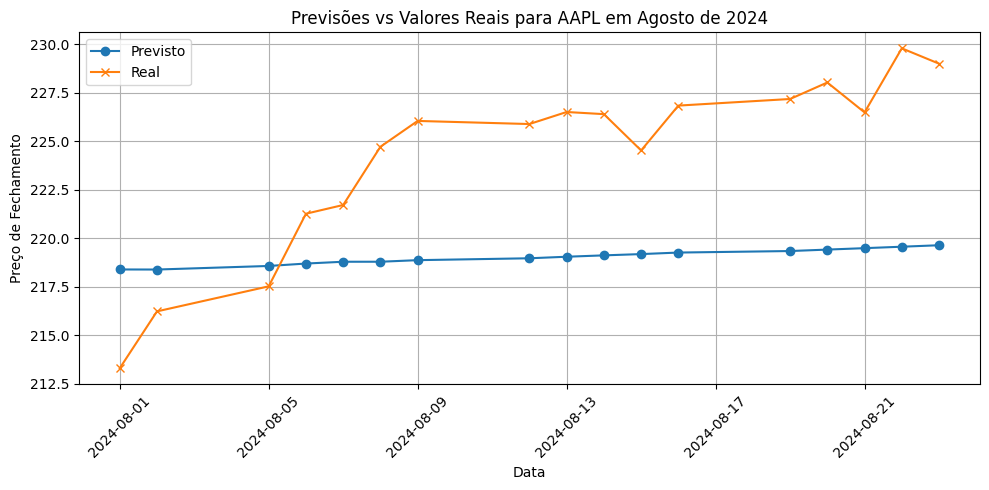


Comparação para MSFT:
                 Data    Previsto        Real
2024-08-01 2024-08-01  424.953596  402.690002
2024-08-02 2024-08-02  424.267607  406.019989
2024-08-05 2024-08-05  425.563331  406.809998
2024-08-06 2024-08-06  425.693364  414.010010
2024-08-07 2024-08-07  425.491353  416.859985
2024-08-08 2024-08-08  426.058223  421.029999
2024-08-09 2024-08-09  426.296155  418.470001
2024-08-12 2024-08-12  426.710932  421.529999
2024-08-13 2024-08-13  426.953314  424.799988
2024-08-14 2024-08-14  427.205885  424.140015
2024-08-15 2024-08-15  427.555719  415.549988
2024-08-16 2024-08-16  427.858653  416.790009
2024-08-19 2024-08-19  428.171920  413.489990
2024-08-20 2024-08-20  428.465754  413.839996
2024-08-21 2024-08-21  428.769075  410.600006
2024-08-22 2024-08-22  429.082721  413.119995
2024-08-23 2024-08-23  429.389169  417.140015


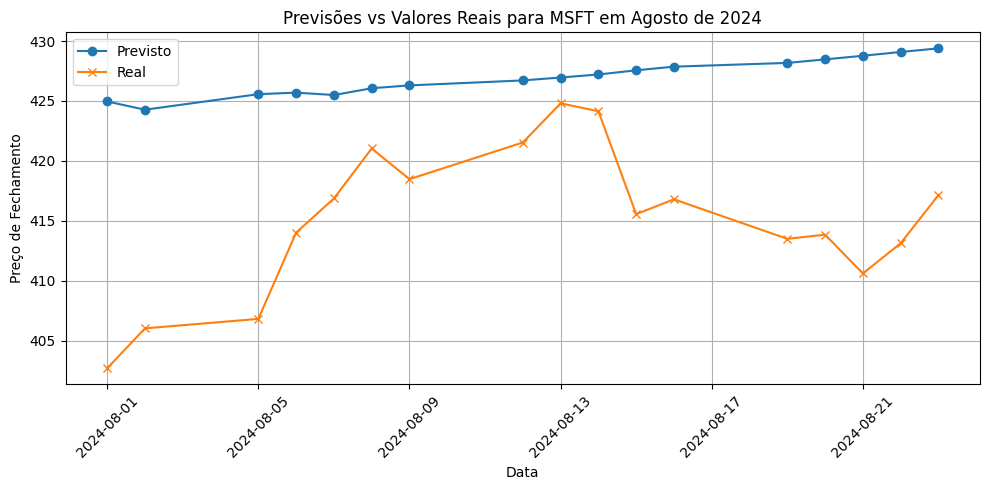


Comparação para PETR4.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  37.379052  36.849998
2024-08-02 2024-08-02  37.273983  36.509998
2024-08-05 2024-08-05  37.193300  37.340000
2024-08-06 2024-08-06  37.104663  37.110001
2024-08-07 2024-08-07  37.182731  37.759998
2024-08-08 2024-08-08  37.296011  38.340000
2024-08-09 2024-08-09  37.339589  38.500000
2024-08-12 2024-08-12  37.355173  38.439999
2024-08-13 2024-08-13  37.390987  38.290001
2024-08-14 2024-08-14  37.456825  38.060001
2024-08-15 2024-08-15  37.511584  37.119999
2024-08-16 2024-08-16  37.558695  36.889999
2024-08-19 2024-08-19  37.602200  39.570000
2024-08-20 2024-08-20  37.653069  39.040001
2024-08-21 2024-08-21  37.705775  39.599998
2024-08-22 2024-08-22  37.756201  39.330002
2024-08-23 2024-08-23  37.805010  39.369999


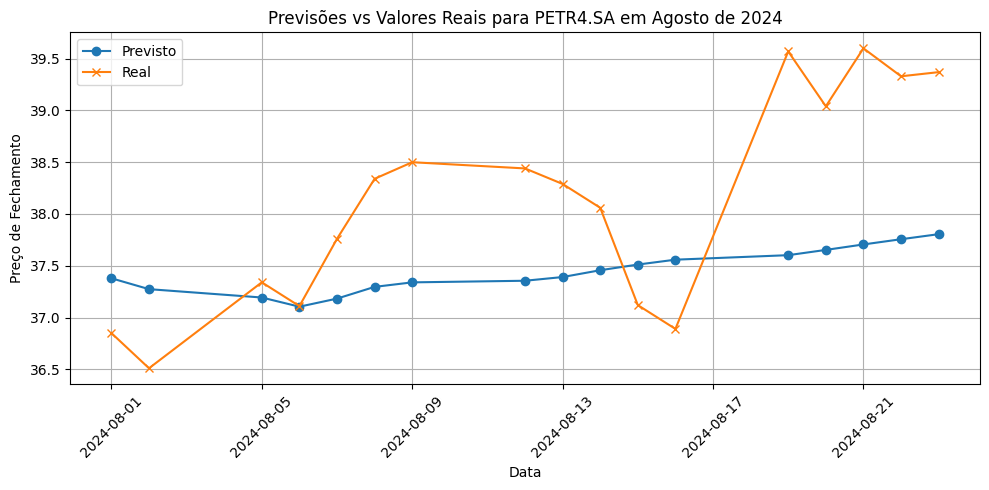


Comparação para VALE3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  60.934741  56.849998
2024-08-02 2024-08-02  60.998232  57.060001
2024-08-05 2024-08-05  61.083806  56.770000
2024-08-06 2024-08-06  61.014467  56.520000
2024-08-07 2024-08-07  60.902017  56.000000
2024-08-08 2024-08-08  61.064916  56.230000
2024-08-09 2024-08-09  61.105206  56.080002
2024-08-12 2024-08-12  61.126647  56.980000
2024-08-13 2024-08-13  61.135556  57.200001
2024-08-14 2024-08-14  61.160289  58.299999
2024-08-15 2024-08-15  61.214053  58.380001
2024-08-16 2024-08-16  61.246749  57.400002
2024-08-19 2024-08-19  61.275050  58.049999
2024-08-20 2024-08-20  61.304695  59.799999
2024-08-21 2024-08-21  61.338747  59.369999
2024-08-22 2024-08-22  61.374435  59.299999
2024-08-23 2024-08-23  61.406910  59.580002


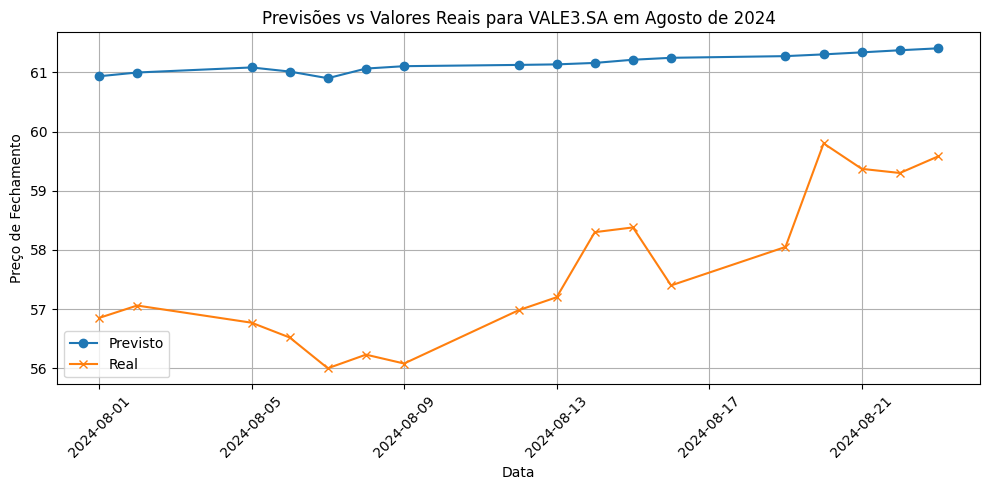


Comparação para ITUB4.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  34.280066  33.650002
2024-08-02 2024-08-02  34.307601  34.560001
2024-08-05 2024-08-05  34.373732  34.610001
2024-08-06 2024-08-06  34.404012  35.590000
2024-08-07 2024-08-07  34.394095  36.470001
2024-08-08 2024-08-08  34.404006  37.049999
2024-08-09 2024-08-09  34.431772  36.740002
2024-08-12 2024-08-12  34.456532  36.959999
2024-08-13 2024-08-13  34.474322  37.230000
2024-08-14 2024-08-14  34.488534  37.080002
2024-08-15 2024-08-15  34.508225  36.740002
2024-08-16 2024-08-16  34.529222  36.459999
2024-08-19 2024-08-19  34.548825  36.540001
2024-08-20 2024-08-20  34.567372  36.580002
2024-08-21 2024-08-21  34.585929  37.369999
2024-08-22 2024-08-22  34.605526  36.959999
2024-08-23 2024-08-23  34.624929  36.700001


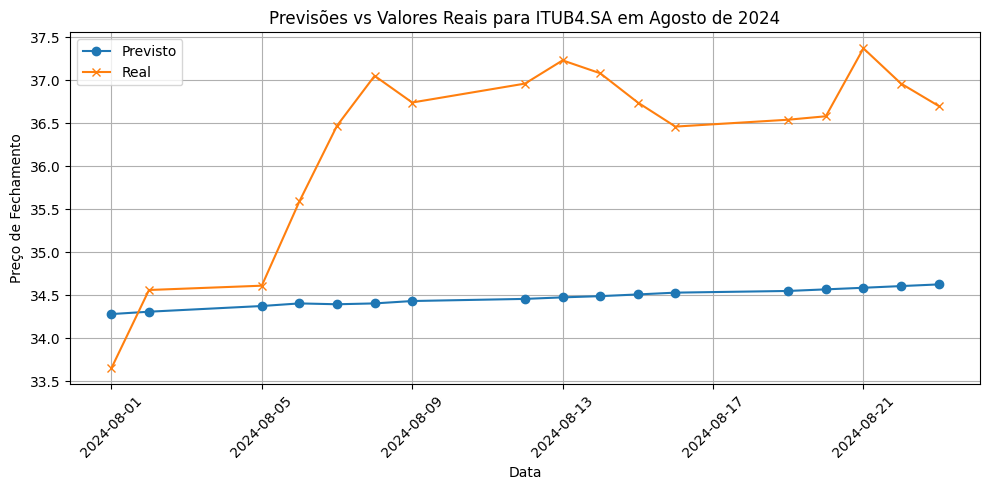


Comparação para BBDC4.SA:
                 Data   Previsto   Real
2024-08-01 2024-08-01  12.482858  14.25
2024-08-02 2024-08-02  12.467764  14.60
2024-08-05 2024-08-05  12.499685  14.70
2024-08-06 2024-08-06  12.511537  14.88
2024-08-07 2024-08-07  12.514431  15.01
2024-08-08 2024-08-08  12.542443  15.16
2024-08-09 2024-08-09  12.557561  14.97
2024-08-12 2024-08-12  12.576744  15.64
2024-08-13 2024-08-13  12.592597  15.70
2024-08-14 2024-08-14  12.608818  15.63
2024-08-15 2024-08-15  12.628297  15.52
2024-08-16 2024-08-16  12.646021  15.66
2024-08-19 2024-08-19  12.663742  15.61
2024-08-20 2024-08-20  12.681152  15.42
2024-08-21 2024-08-21  12.698877  15.67
2024-08-22 2024-08-22  12.716910  15.63
2024-08-23 2024-08-23  12.734715  15.64


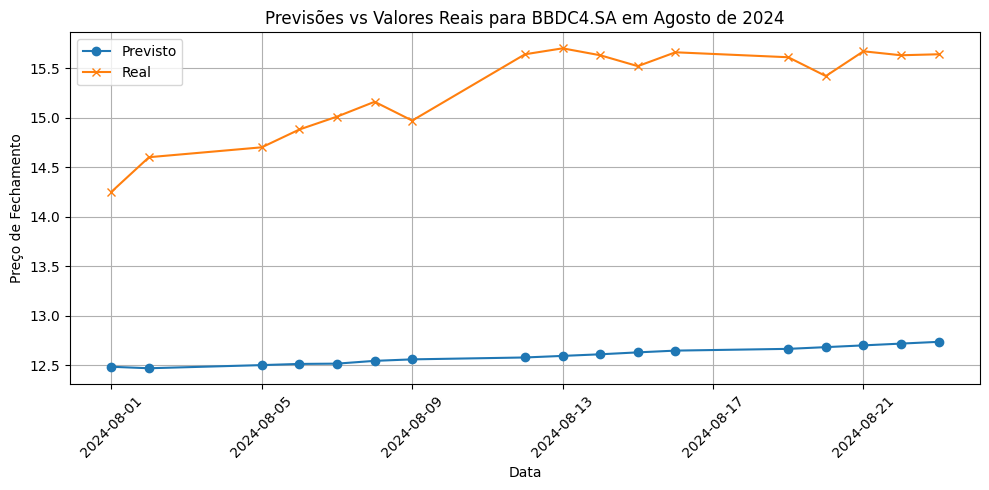


Comparação para BBAS3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  27.005006  26.190001
2024-08-02 2024-08-02  27.032020  26.549999
2024-08-05 2024-08-05  27.060395  27.120001
2024-08-06 2024-08-06  27.048675  27.469999
2024-08-07 2024-08-07  27.026449  27.930000
2024-08-08 2024-08-08  27.042033  28.150000
2024-08-09 2024-08-09  27.049467  28.370001
2024-08-12 2024-08-12  27.052963  29.129999
2024-08-13 2024-08-13  27.051500  29.260000
2024-08-14 2024-08-14  27.052069  29.129999
2024-08-15 2024-08-15  27.057218  28.010000
2024-08-16 2024-08-16  27.060265  28.219999
2024-08-19 2024-08-19  27.062426  28.330000
2024-08-20 2024-08-20  27.064317  28.010000
2024-08-21 2024-08-21  27.066882  28.180000
2024-08-22 2024-08-22  27.069843  28.299999
2024-08-23 2024-08-23  27.072368  28.120001


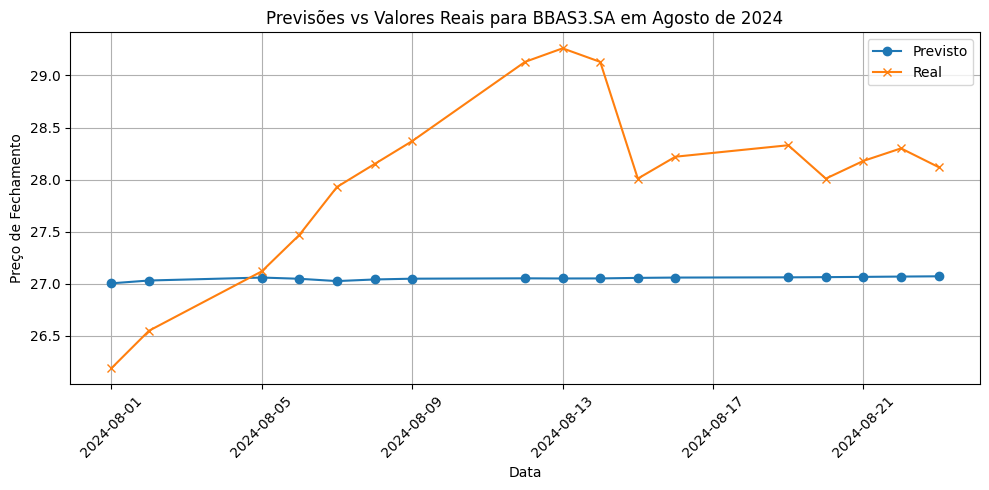


Comparação para ABEV3.SA:
                 Data   Previsto   Real
2024-08-01 2024-08-01  11.804952  12.36
2024-08-02 2024-08-02  11.806181  12.45
2024-08-05 2024-08-05  11.797612  12.39
2024-08-06 2024-08-06  11.781234  12.57
2024-08-07 2024-08-07  11.773602  12.56
2024-08-08 2024-08-08  11.802528  13.03
2024-08-09 2024-08-09  11.805105  13.01
2024-08-12 2024-08-12  11.804887  13.01
2024-08-13 2024-08-13  11.806372  12.94
2024-08-14 2024-08-14  11.811550  12.94
2024-08-15 2024-08-15  11.819228  13.00
2024-08-16 2024-08-16  11.823018  13.08
2024-08-19 2024-08-19  11.826599  13.08
2024-08-20 2024-08-20  11.830979  13.03
2024-08-21 2024-08-21  11.835928  12.95
2024-08-22 2024-08-22  11.840800  12.86
2024-08-23 2024-08-23  11.845164  12.86


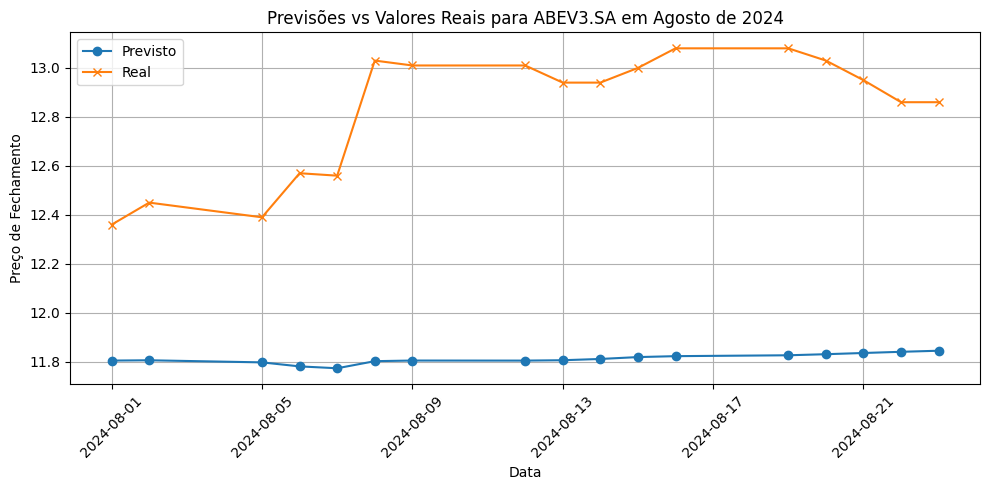


Comparação para B3SA3.SA:
                 Data   Previsto   Real
2024-08-01 2024-08-01  10.901307  11.35
2024-08-02 2024-08-02  10.877650  12.02
2024-08-05 2024-08-05  10.872418  12.20
2024-08-06 2024-08-06  10.856695  12.64
2024-08-07 2024-08-07  10.857425  12.70
2024-08-08 2024-08-08  10.876028  12.71
2024-08-09 2024-08-09  10.868197  12.49
2024-08-12 2024-08-12  10.866136  12.79
2024-08-13 2024-08-13  10.864875  12.90
2024-08-14 2024-08-14  10.866364  12.96
2024-08-15 2024-08-15  10.868149  12.54
2024-08-16 2024-08-16  10.866255  12.74
2024-08-19 2024-08-19  10.865762  12.80
2024-08-20 2024-08-20  10.865675  12.65
2024-08-21 2024-08-21  10.865828  12.70
2024-08-22 2024-08-22  10.865711  12.54
2024-08-23 2024-08-23  10.865198  12.68


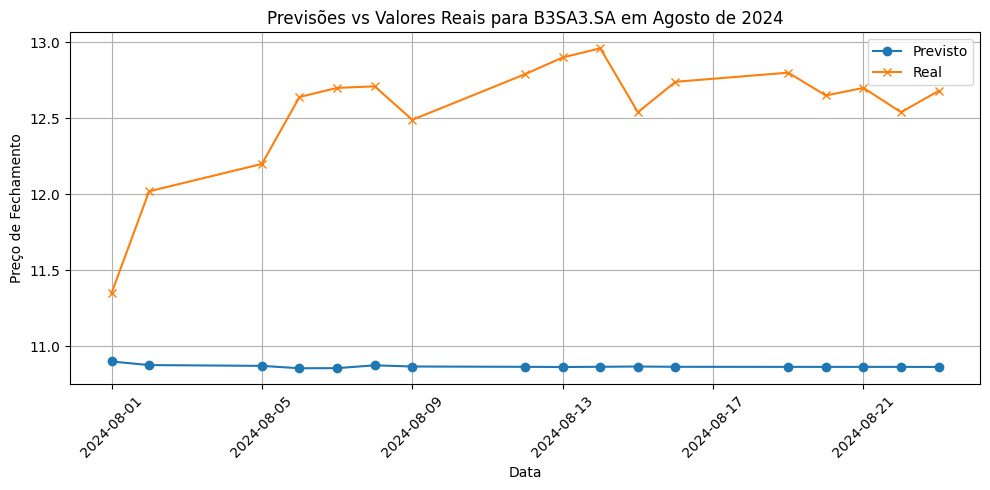


Comparação para WEGE3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  46.411875  49.689999
2024-08-02 2024-08-02  46.366785  49.700001
2024-08-05 2024-08-05  46.447012  50.580002
2024-08-06 2024-08-06  46.344912  51.130001
2024-08-07 2024-08-07  46.316485  51.540001
2024-08-08 2024-08-08  46.402407  52.700001
2024-08-09 2024-08-09  46.393921  53.250000
2024-08-12 2024-08-12  46.399236  51.790001
2024-08-13 2024-08-13  46.389272  53.110001
2024-08-14 2024-08-14  46.397340  53.430000
2024-08-15 2024-08-15  46.413343  54.200001
2024-08-16 2024-08-16  46.414515  53.810001
2024-08-19 2024-08-19  46.418579  54.080002
2024-08-20 2024-08-20  46.422449  54.000000
2024-08-21 2024-08-21  46.428954  54.000000
2024-08-22 2024-08-22  46.435277  53.540001
2024-08-23 2024-08-23  46.439539  54.150002


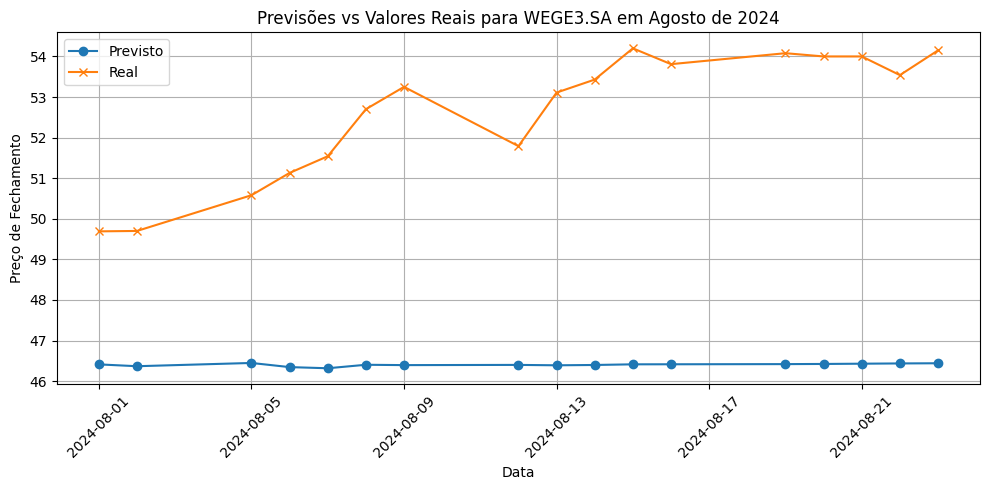


Comparação para RENT3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  43.000336  48.470001
2024-08-02 2024-08-02  42.971679  48.849998
2024-08-05 2024-08-05  42.953069  49.220001
2024-08-06 2024-08-06  42.735890  48.099998
2024-08-07 2024-08-07  42.718544  40.000000
2024-08-08 2024-08-08  42.837530  39.200001
2024-08-09 2024-08-09  42.743996  42.599998
2024-08-12 2024-08-12  42.698991  44.250000
2024-08-13 2024-08-13  42.648051  42.970001
2024-08-14 2024-08-14  42.623547  43.700001
2024-08-15 2024-08-15  42.604568  41.939999
2024-08-16 2024-08-16  42.549138  42.299999
2024-08-19 2024-08-19  42.507947  42.279999
2024-08-20 2024-08-20  42.469715  42.900002
2024-08-21 2024-08-21  42.433797  42.500000
2024-08-22 2024-08-22  42.395628  41.750000
2024-08-23 2024-08-23  42.352961  41.369999


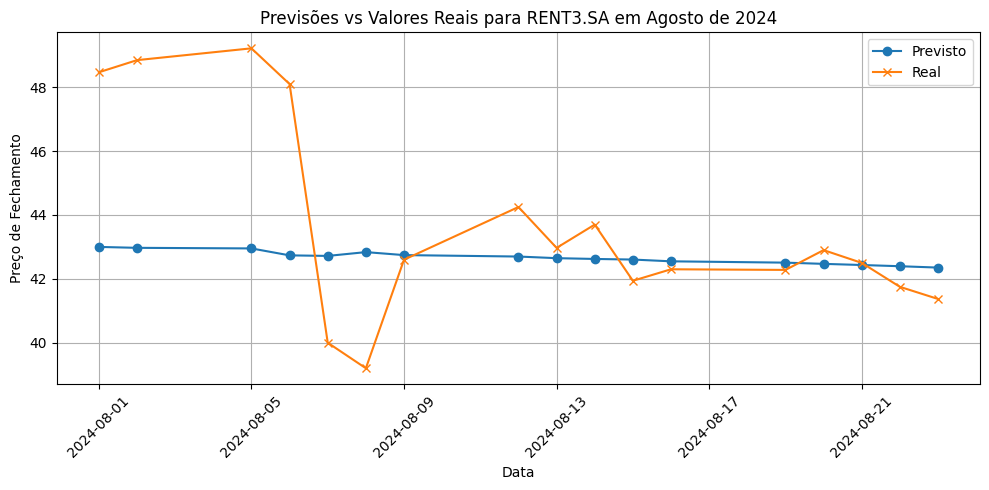


Comparação para JBSS3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  32.622446  32.740002
2024-08-02 2024-08-02  32.998977  33.310001
2024-08-05 2024-08-05  33.410357  33.490002
2024-08-06 2024-08-06  33.473613  34.900002
2024-08-07 2024-08-07  33.451099  37.340000
2024-08-08 2024-08-08  33.223608  37.919998
2024-08-09 2024-08-09  33.316629  36.450001
2024-08-12 2024-08-12  33.378476  38.160000
2024-08-13 2024-08-13  33.367989  36.130001
2024-08-14 2024-08-14  33.346633  36.549999
2024-08-15 2024-08-15  33.325740  36.209999
2024-08-16 2024-08-16  33.343289  34.830002
2024-08-19 2024-08-19  33.347890  35.000000
2024-08-20 2024-08-20  33.341030  34.980000
2024-08-21 2024-08-21  33.335632  35.040001
2024-08-22 2024-08-22  33.333333  34.939999
2024-08-23 2024-08-23  33.334678  35.000000


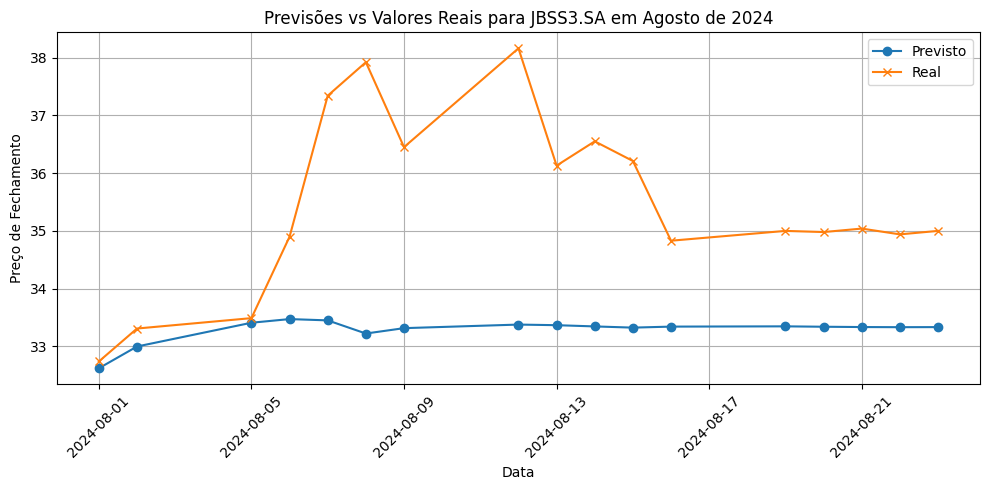


Comparação para MGLU3.SA:
                 Data   Previsto   Real
2024-08-01 2024-08-01  11.529290  12.54
2024-08-02 2024-08-02  11.500967  12.96
2024-08-05 2024-08-05  11.481148  12.95
2024-08-06 2024-08-06  11.399404  13.29
2024-08-07 2024-08-07  11.439727  12.74
2024-08-08 2024-08-08  11.511767  13.29
2024-08-09 2024-08-09  11.508673  12.58
2024-08-12 2024-08-12  11.510219  13.92
2024-08-13 2024-08-13  11.516040  13.80
2024-08-14 2024-08-14  11.539449  13.85
2024-08-15 2024-08-15  11.559411  13.18
2024-08-16 2024-08-16  11.568995  13.62
2024-08-19 2024-08-19  11.581074  13.35
2024-08-20 2024-08-20  11.595260  13.47
2024-08-21 2024-08-21  11.611119  13.18
2024-08-22 2024-08-22  11.625467  12.89
2024-08-23 2024-08-23  11.638691  12.16


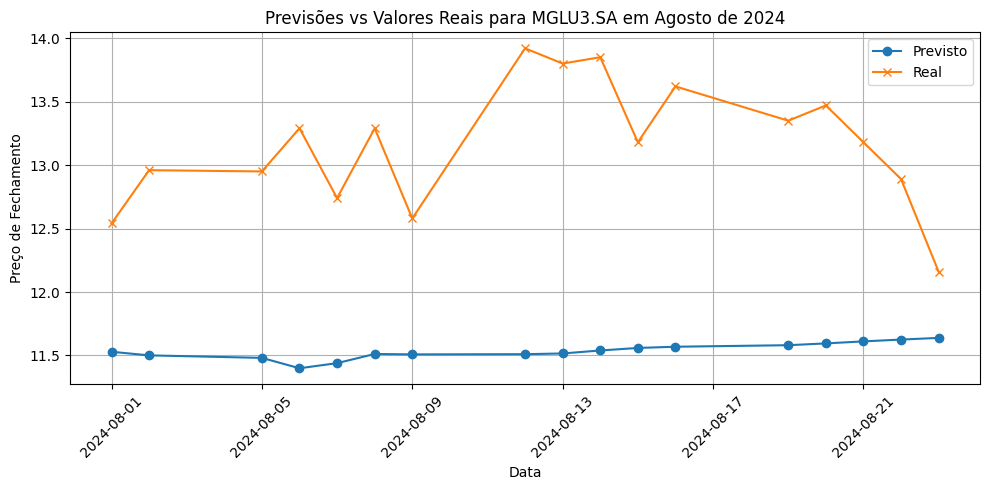


Comparação para BRFS3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  21.183372  21.540001
2024-08-02 2024-08-02  21.259904  21.930000
2024-08-05 2024-08-05  21.299758  21.850000
2024-08-06 2024-08-06  21.217490  22.450001
2024-08-07 2024-08-07  21.189159  23.510000
2024-08-08 2024-08-08  21.162885  23.910000
2024-08-09 2024-08-09  21.155267  24.299999
2024-08-12 2024-08-12  21.131640  25.250000
2024-08-13 2024-08-13  21.095766  25.400000
2024-08-14 2024-08-14  21.068842  26.030001
2024-08-15 2024-08-15  21.044764  25.709999
2024-08-16 2024-08-16  21.021130  25.190001
2024-08-19 2024-08-19  20.993575  25.299999
2024-08-20 2024-08-20  20.965915  25.910000
2024-08-21 2024-08-21  20.939522  26.030001
2024-08-22 2024-08-22  20.913653  25.799999
2024-08-23 2024-08-23  20.887388  26.230000


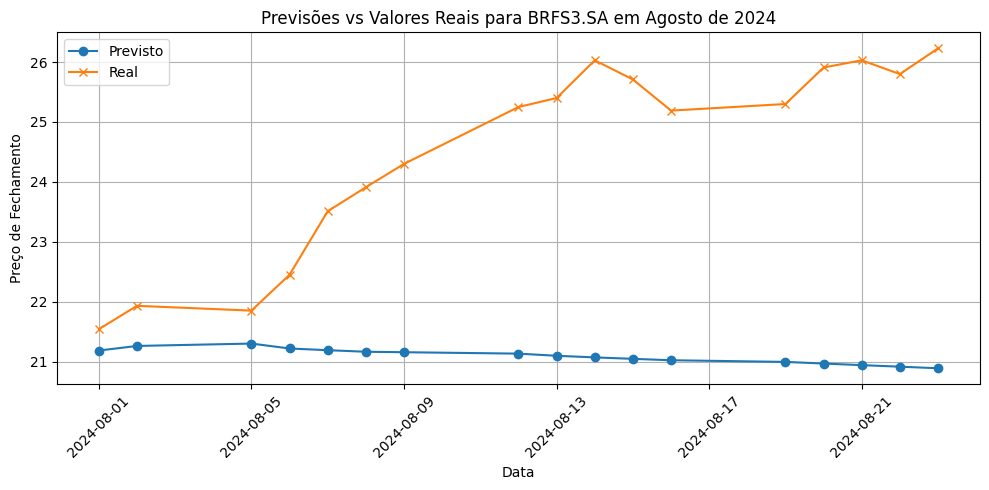


Comparação para SUZB3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  52.674919  53.599998
2024-08-02 2024-08-02  52.611022  54.500000
2024-08-05 2024-08-05  52.635492  54.389999
2024-08-06 2024-08-06  52.795546  54.540001
2024-08-07 2024-08-07  52.784180  54.700001
2024-08-08 2024-08-08  52.645806  53.580002
2024-08-09 2024-08-09  52.620641  54.410000
2024-08-12 2024-08-12  52.622254  55.040001
2024-08-13 2024-08-13  52.619557  55.869999
2024-08-14 2024-08-14  52.580580  56.459999
2024-08-15 2024-08-15  52.539865  56.410000
2024-08-16 2024-08-16  52.515750  56.080002
2024-08-19 2024-08-19  52.494834  55.180000
2024-08-20 2024-08-20  52.469079  55.619999
2024-08-21 2024-08-21  52.438562  56.080002
2024-08-22 2024-08-22  52.410137  55.500000
2024-08-23 2024-08-23  52.383955  55.000000


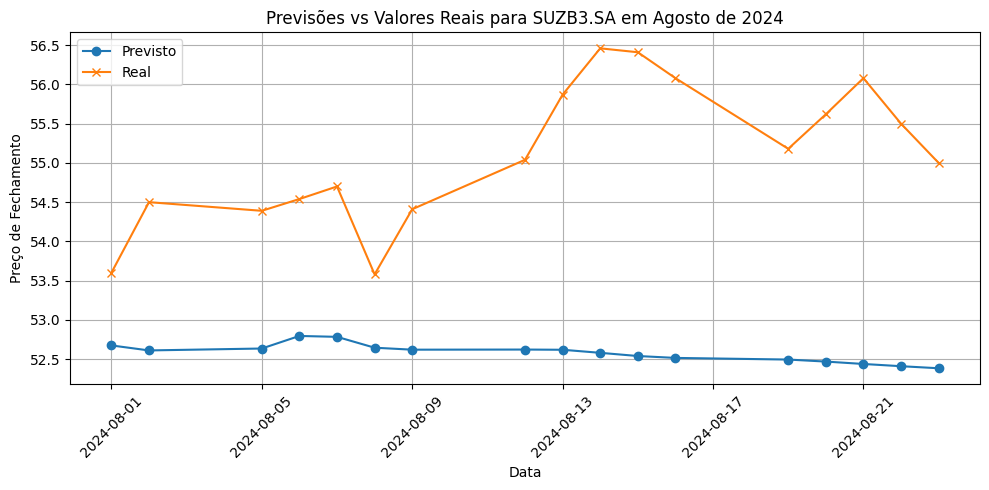


Comparação para ELET3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  37.882101  38.619999
2024-08-02 2024-08-02  37.999779  39.860001
2024-08-05 2024-08-05  38.074524  39.419998
2024-08-06 2024-08-06  37.995673  39.790001
2024-08-07 2024-08-07  37.955690  40.150002
2024-08-08 2024-08-08  37.946226  40.500000
2024-08-09 2024-08-09  37.957738  40.340000
2024-08-12 2024-08-12  37.947467  41.529999
2024-08-13 2024-08-13  37.920298  41.400002
2024-08-14 2024-08-14  37.904021  41.500000
2024-08-15 2024-08-15  37.893264  40.900002
2024-08-16 2024-08-16  37.882670  41.880001
2024-08-19 2024-08-19  37.867119  41.880001
2024-08-20 2024-08-20  37.851008  41.400002
2024-08-21 2024-08-21  37.836852  42.040001
2024-08-22 2024-08-22  37.823393  41.299999
2024-08-23 2024-08-23  37.809381  41.750000


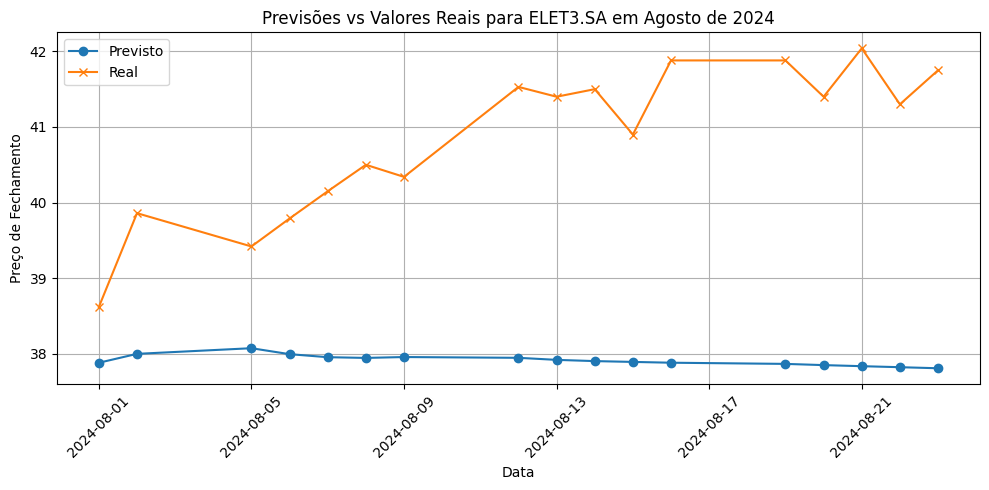

In [206]:
for ticker in tickers:
    actual_prices = real_data_prepared[ticker]['Close'].values[:len(future_data[ticker])]
    predicted_prices = future_data[ticker]

    # Garantir que ambos tenham o mesmo comprimento
    min_length = min(len(actual_prices), len(predicted_prices))

    comparison_df = pd.DataFrame({
        'Data': future_dates[:min_length],
        'Previsto': predicted_prices[:min_length],
        'Real': actual_prices[:min_length]
    })
    
    print(f'\nComparação para {ticker}:')
    print(comparison_df)

    # Plotar os resultados
    plt.figure(figsize=(10, 5))
    plt.plot(comparison_df['Data'], comparison_df['Previsto'], label='Previsto', marker='o')
    plt.plot(comparison_df['Data'], comparison_df['Real'], label='Real', marker='x')
    plt.title(f'Previsões vs Valores Reais para {ticker} em Agosto de 2024')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Modelo de ML com RandomForestRegressor

### Extracao dos dados da lib yFinance
- Definicao das acoes que serao analisadas, colocando em uma lista.
- Define uma data inicial e limite

In [207]:
warnings.filterwarnings('ignore')

tickers = ['AAPL', 'MSFT', 'PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 
           'BBAS3.SA', 'ABEV3.SA', 'B3SA3.SA', 'WEGE3.SA', 'RENT3.SA', 
           'JBSS3.SA', 'MGLU3.SA', 'BRFS3.SA', 'SUZB3.SA', 'ELET3.SA']  # Adicione os tickers desejados
start_date = '2015-01-01'
end_date = '2024-07-31'

- Download dos dados a partir da data 

In [208]:
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Preparar os dados 
- Calculo do RSI (ajuda a analisar a força de uma tendência e a velocidade de movimentação de preços de um ativo.) 

In [209]:
def compute_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

- Preparar os dados para cada papel

In [210]:
def prepare_data(df):
    df['Date'] = df.index
    df['Return'] = df['Close'].pct_change()
    df['Moving_Average'] = df['Close'].rolling(window=5).mean()
    df['Volatility'] = df['Return'].rolling(window=5).std()
    df['RSI'] = compute_rsi(df['Close'])
    df.dropna(inplace=True)
    return df[['Date', 'Close', 'Moving_Average', 'Volatility', 'RSI']]

- Aplica a funcao nas acoes da lista de tickers

In [211]:
prepared_data = {}
for ticker in tickers:
    prepared_data[ticker] = prepare_data(data[ticker])

### Treinamento do modelo 
- Separacao dos dados para treino de 80% e teste de 20%
- Avaliacao do modelo de acordo com metricas como MSE e MAE

In [212]:
# Treinamento e teste para previsão
def train_and_predict(df, ticker):
    X = df[['Moving_Average', 'Volatility', 'RSI']]
    y = df['Close']

    # Divisão dos dados
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modelo de Regressão Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Previsão
    y_pred = model.predict(X_test)

    # Avaliação
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Modelo para {ticker}:')
    print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')

    return model

- Aplicando a funcao de treino e previsao na lista de acoes
- Previsoes para o mes de agosto de 2024 (MAE e MSE)

In [213]:
models = {}
for ticker in tickers:
    models[ticker] = train_and_predict(prepared_data[ticker], ticker)


future_dates = pd.date_range(start='2024-08-01', end='2024-08-31', freq='B')  # Dias úteis
future_data = pd.DataFrame(index=future_dates)

Modelo para AAPL:
MSE: 4.18, MAE: 1.22
Modelo para MSFT:
MSE: 10.15, MAE: 2.07
Modelo para PETR4.SA:
MSE: 0.41, MAE: 0.41
Modelo para VALE3.SA:
MSE: 1.71, MAE: 0.90
Modelo para ITUB4.SA:
MSE: 0.22, MAE: 0.35
Modelo para BBDC4.SA:
MSE: 0.14, MAE: 0.26
Modelo para BBAS3.SA:
MSE: 0.16, MAE: 0.29
Modelo para ABEV3.SA:
MSE: 0.07, MAE: 0.19
Modelo para B3SA3.SA:
MSE: 0.08, MAE: 0.19
Modelo para WEGE3.SA:
MSE: 0.26, MAE: 0.32
Modelo para RENT3.SA:
MSE: 0.91, MAE: 0.62
Modelo para JBSS3.SA:
MSE: 0.30, MAE: 0.38
Modelo para MGLU3.SA:
MSE: 6.03, MAE: 1.38
Modelo para BRFS3.SA:
MSE: 0.49, MAE: 0.50
Modelo para SUZB3.SA:
MSE: 1.09, MAE: 0.79
Modelo para ELET3.SA:
MSE: 0.68, MAE: 0.56


### Previsao de resultados
- Previsao para cada acao em datas futuras

In [214]:
for ticker in tickers:
    predictions = []
    last_moving_average = prepared_data[ticker]['Moving_Average'].iloc[-1]
    last_volatility = prepared_data[ticker]['Volatility'].iloc[-1]
    last_rsi = prepared_data[ticker]['RSI'].iloc[-1]
    last_close = prepared_data[ticker]['Close'].iloc[-1]

    for date in future_dates:
        # Prever o próximo valor
        prediction = models[ticker].predict(np.array([[last_moving_average, last_volatility, last_rsi]]).reshape(1, -1))
        predictions.append(prediction[0])
        
        # Atualiza os dados para a próxima previsão
        new_row = pd.Series({
            'Moving_Average': last_moving_average,
            'Volatility': last_volatility,
            'RSI': last_rsi,
            'Close': prediction[0]
        }, name=date)
        
        prepared_data[ticker] = pd.concat([prepared_data[ticker], new_row.to_frame().T])

        # Atualizando os valores para a próxima iteração
        last_close = prediction[0]
        
        # Recalcula 'Return', 'Moving_Average', 'Volatility' e 'RSI'
        prepared_data[ticker]['Return'] = prepared_data[ticker]['Close'].pct_change()
        last_moving_average = prepared_data[ticker]['Close'].rolling(window=5).mean().iloc[-1]
        last_volatility = prepared_data[ticker]['Return'].rolling(window=5).std().iloc[-1]
        last_rsi = compute_rsi(prepared_data[ticker]['Close']).iloc[-1]

    future_data[ticker] = predictions

- Download dos dados de Agosto de 2024 de cada acao
- Preparar os dados de Agosto de 2024

In [215]:
real_data = {}
for ticker in tickers:
    real_data[ticker] = yf.download(ticker, start='2024-08-01', end='2024-09-01')

# Preparar os dados reais
real_data_prepared = {}
for ticker in tickers:
    real_data_prepared[ticker] = prepare_data(real_data[ticker])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Comparar os dados 
- Comparacao de dados reais de dados previstos
- Plostagem da comparacao entre os valores


Comparação para AAPL:
                 Data    Previsto        Real
2024-08-01 2024-08-01  218.560804  226.509995
2024-08-02 2024-08-02  218.061205  226.399994
2024-08-05 2024-08-05  218.141505  224.529999
2024-08-06 2024-08-06  218.141505  226.839996
2024-08-07 2024-08-07  218.141505  227.179993
2024-08-08 2024-08-08  218.141505  228.029999
2024-08-09 2024-08-09  218.141505  226.490005
2024-08-12 2024-08-12  218.141505  229.789993
2024-08-13 2024-08-13  218.141505  229.000000


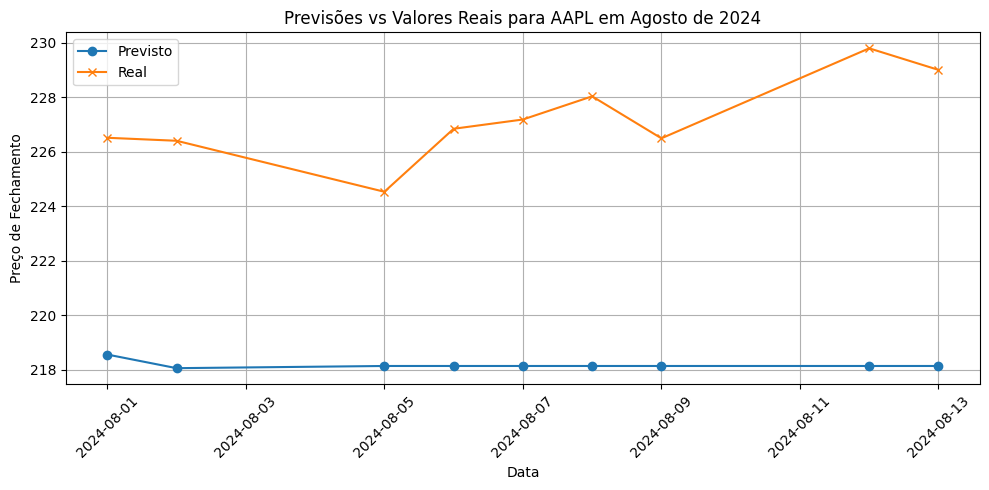


Comparação para MSFT:
                 Data    Previsto        Real
2024-08-01 2024-08-01  421.876809  424.799988
2024-08-02 2024-08-02  415.782704  424.140015
2024-08-05 2024-08-05  416.121504  415.549988
2024-08-06 2024-08-06  415.006501  416.790009
2024-08-07 2024-08-07  414.833399  413.489990
2024-08-08 2024-08-08  414.800299  413.839996
2024-08-09 2024-08-09  413.171999  410.600006
2024-08-12 2024-08-12  411.552699  413.119995
2024-08-13 2024-08-13  409.041198  417.140015


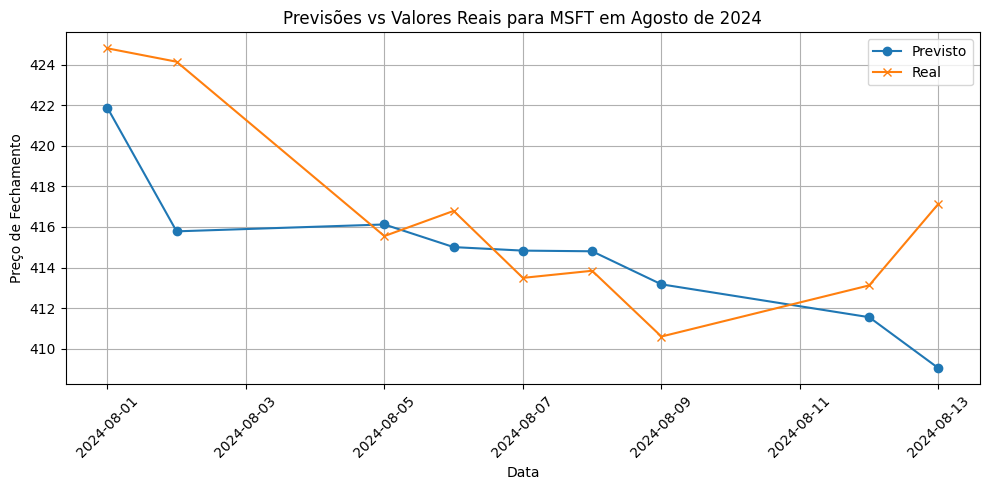


Comparação para PETR4.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  37.036901  38.290001
2024-08-02 2024-08-02  37.350100  38.060001
2024-08-05 2024-08-05  37.558700  37.119999
2024-08-06 2024-08-06  37.638600  36.889999
2024-08-07 2024-08-07  37.430600  39.570000
2024-08-08 2024-08-08  37.511500  39.040001
2024-08-09 2024-08-09  37.683700  39.599998
2024-08-12 2024-08-12  37.704400  39.330002
2024-08-13 2024-08-13  37.891300  39.369999


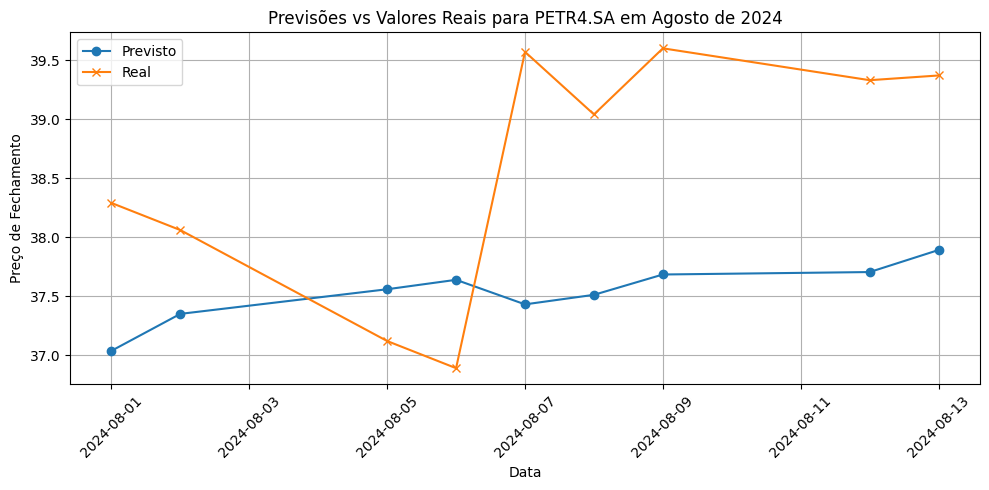


Comparação para VALE3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  60.401801  57.200001
2024-08-02 2024-08-02  60.507601  58.299999
2024-08-05 2024-08-05  60.809400  58.380001
2024-08-06 2024-08-06  60.871600  57.400002
2024-08-07 2024-08-07  59.587601  58.049999
2024-08-08 2024-08-08  59.512501  59.799999
2024-08-09 2024-08-09  59.754201  59.369999
2024-08-12 2024-08-12  59.163401  59.299999
2024-08-13 2024-08-13  59.147200  59.580002


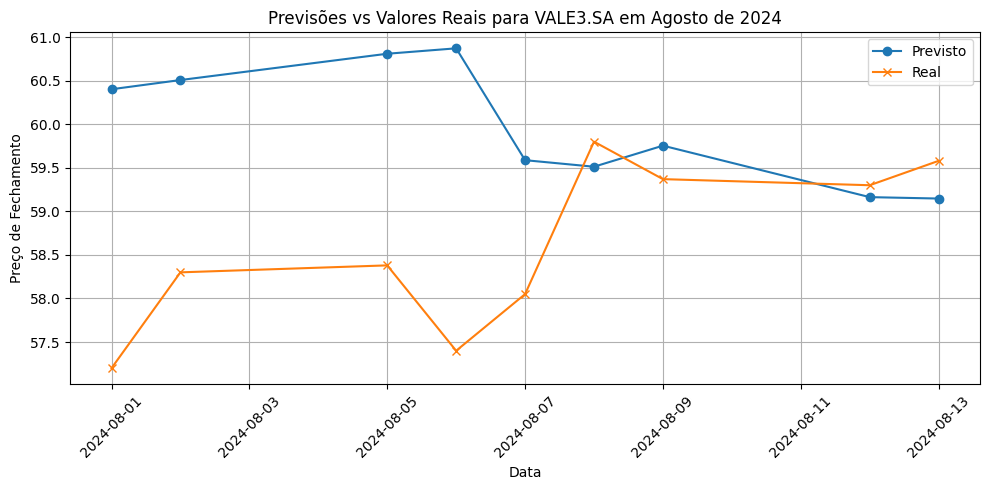


Comparação para ITUB4.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  34.400634  37.230000
2024-08-02 2024-08-02  34.472034  37.080002
2024-08-05 2024-08-05  34.508933  36.740002
2024-08-06 2024-08-06  34.668700  36.459999
2024-08-07 2024-08-07  34.653566  36.540001
2024-08-08 2024-08-08  34.665899  36.580002
2024-08-09 2024-08-09  34.637833  37.369999
2024-08-12 2024-08-12  34.582133  36.959999
2024-08-13 2024-08-13  34.584599  36.700001


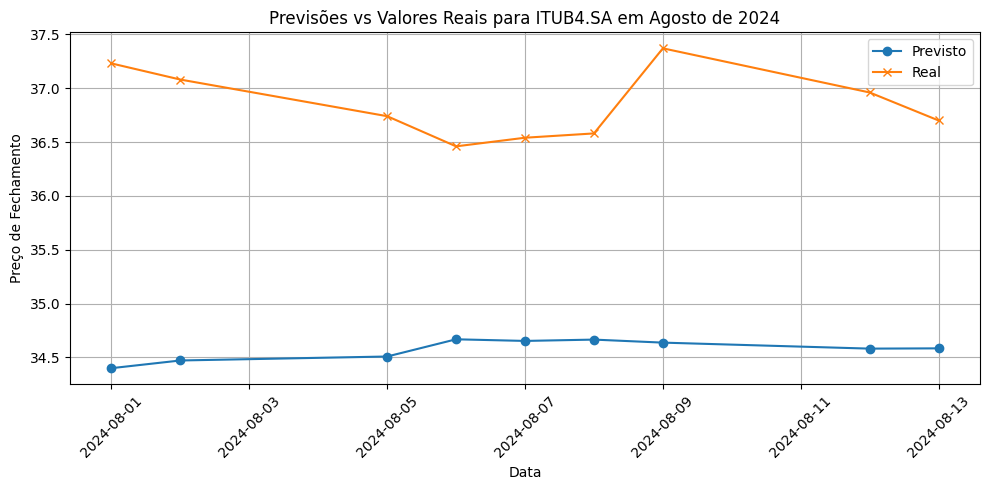


Comparação para BBDC4.SA:
                 Data   Previsto   Real
2024-08-01 2024-08-01  12.402580  15.70
2024-08-02 2024-08-02  12.416334  15.63
2024-08-05 2024-08-05  12.442434  15.52
2024-08-06 2024-08-06  12.445265  15.66
2024-08-07 2024-08-07  12.449791  15.61
2024-08-08 2024-08-08  12.381023  15.42
2024-08-09 2024-08-09  12.412575  15.67
2024-08-12 2024-08-12  12.445489  15.63
2024-08-13 2024-08-13  12.368886  15.64


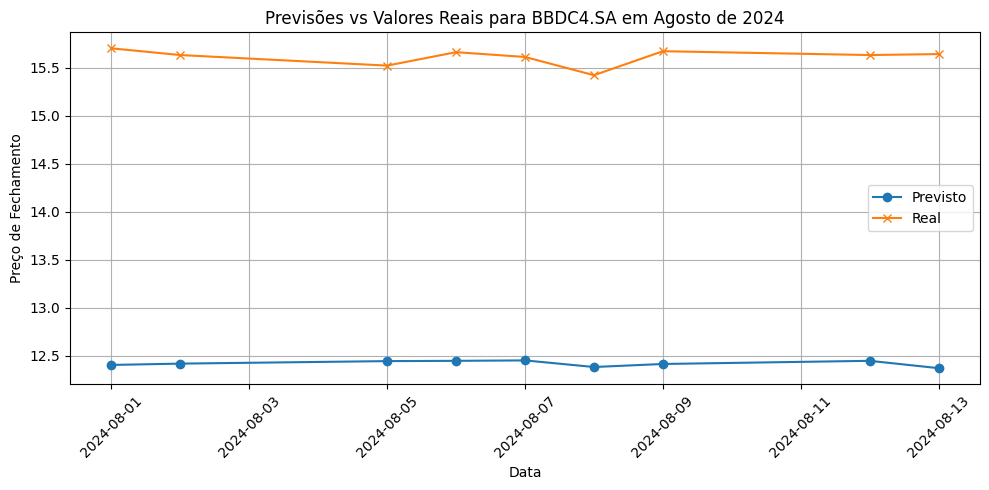


Comparação para BBAS3.SA:
                 Data  Previsto       Real
2024-08-01 2024-08-01  26.94050  29.260000
2024-08-02 2024-08-02  27.05800  29.129999
2024-08-05 2024-08-05  27.11740  28.010000
2024-08-06 2024-08-06  27.14275  28.219999
2024-08-07 2024-08-07  27.11885  28.330000
2024-08-08 2024-08-08  26.91045  28.010000
2024-08-09 2024-08-09  27.05880  28.180000
2024-08-12 2024-08-12  27.05125  28.299999
2024-08-13 2024-08-13  27.04135  28.120001


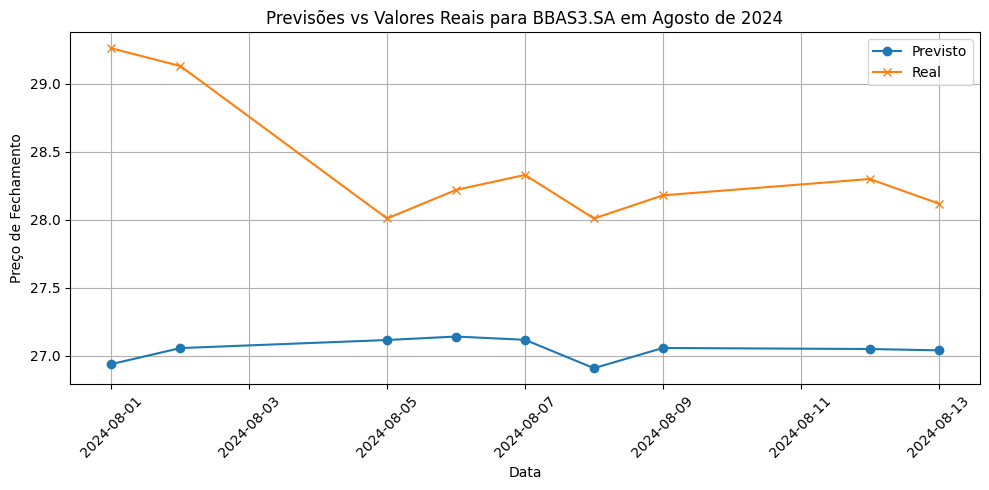


Comparação para ABEV3.SA:
                 Data  Previsto   Real
2024-08-01 2024-08-01   11.6948  12.94
2024-08-02 2024-08-02   11.7568  12.94
2024-08-05 2024-08-05   11.7662  13.00
2024-08-06 2024-08-06   11.7856  13.08
2024-08-07 2024-08-07   11.7749  13.08
2024-08-08 2024-08-08   11.7065  13.03
2024-08-09 2024-08-09   11.7514  12.95
2024-08-12 2024-08-12   11.7611  12.86
2024-08-13 2024-08-13   11.7117  12.86


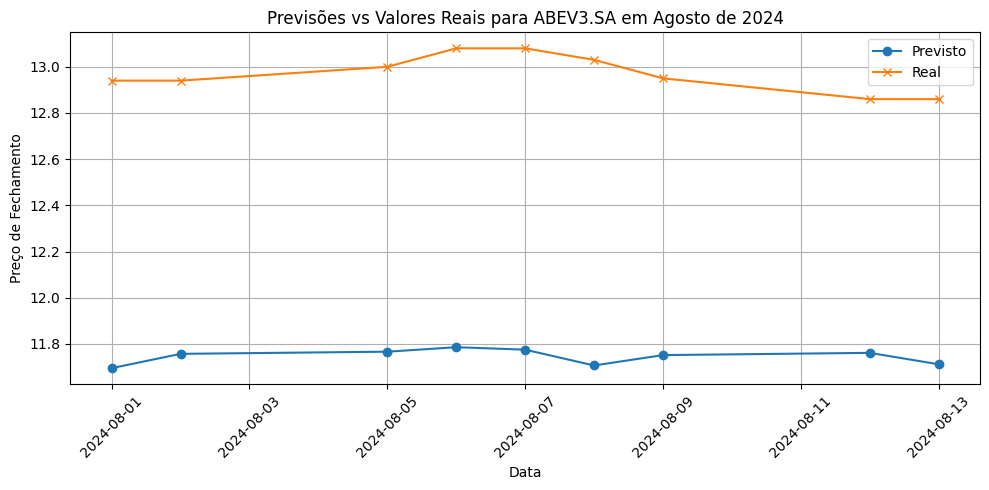


Comparação para B3SA3.SA:
                 Data   Previsto   Real
2024-08-01 2024-08-01  10.734167  12.90
2024-08-02 2024-08-02  10.672966  12.96
2024-08-05 2024-08-05  10.637933  12.54
2024-08-06 2024-08-06  10.599433  12.74
2024-08-07 2024-08-07  10.559266  12.80
2024-08-08 2024-08-08  10.565767  12.65
2024-08-09 2024-08-09  10.498700  12.70
2024-08-12 2024-08-12  10.524967  12.54
2024-08-13 2024-08-13  10.521667  12.68


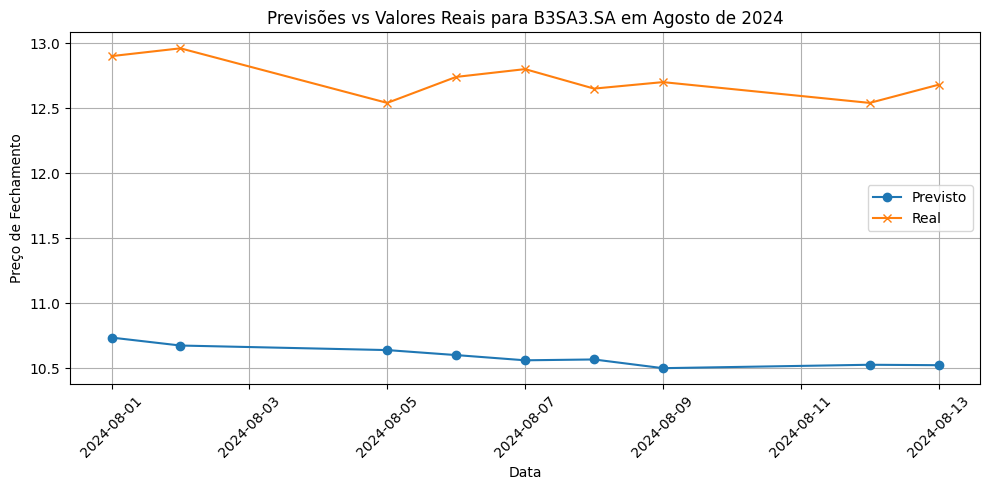


Comparação para WEGE3.SA:
                 Data  Previsto       Real
2024-08-01 2024-08-01  45.99035  53.110001
2024-08-02 2024-08-02  45.95040  53.430000
2024-08-05 2024-08-05  46.12845  54.200001
2024-08-06 2024-08-06  46.12620  53.810001
2024-08-07 2024-08-07  46.11735  54.080002
2024-08-08 2024-08-08  46.04535  54.000000
2024-08-09 2024-08-09  46.05390  54.000000
2024-08-12 2024-08-12  46.06575  53.540001
2024-08-13 2024-08-13  46.05390  54.150002


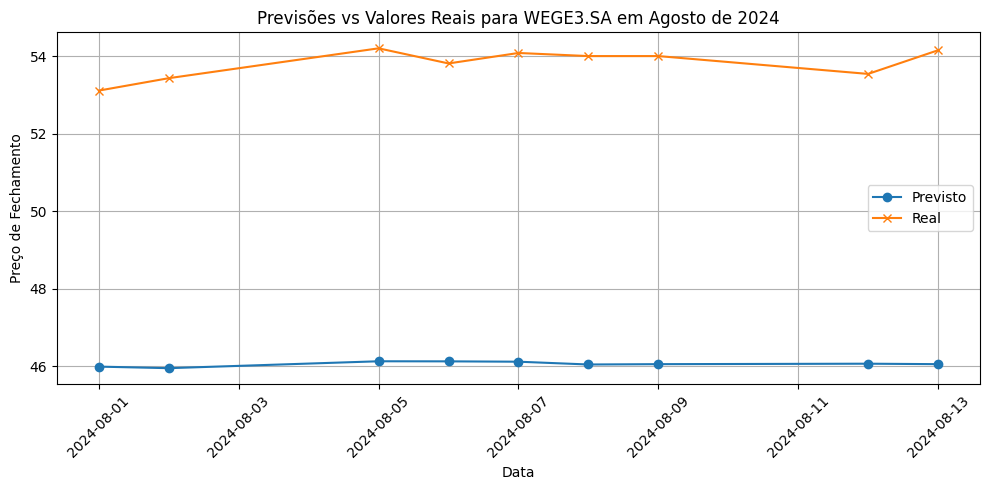


Comparação para RENT3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  42.366019  42.970001
2024-08-02 2024-08-02  42.318104  43.700001
2024-08-05 2024-08-05  41.577549  41.939999
2024-08-06 2024-08-06  41.317677  42.299999
2024-08-07 2024-08-07  41.137386  42.279999
2024-08-08 2024-08-08  40.877261  42.900002
2024-08-09 2024-08-09  40.960130  42.500000
2024-08-12 2024-08-12  40.900168  41.750000
2024-08-13 2024-08-13  40.894567  41.369999


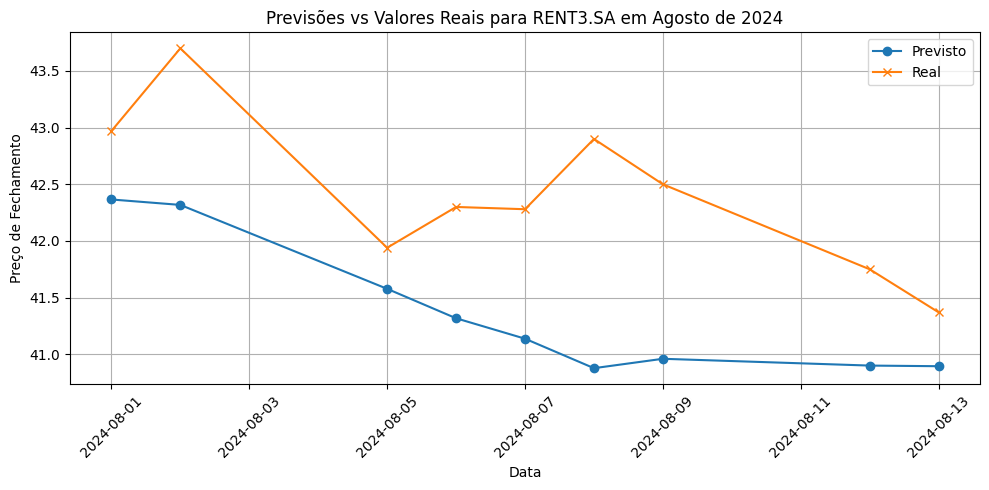


Comparação para JBSS3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  33.914101  36.130001
2024-08-02 2024-08-02  32.457100  36.549999
2024-08-05 2024-08-05  33.010201  36.209999
2024-08-06 2024-08-06  33.610100  34.830002
2024-08-07 2024-08-07  33.581700  35.000000
2024-08-08 2024-08-08  32.789600  34.980000
2024-08-09 2024-08-09  33.102000  35.040001
2024-08-12 2024-08-12  32.663299  34.939999
2024-08-13 2024-08-13  32.597699  35.000000


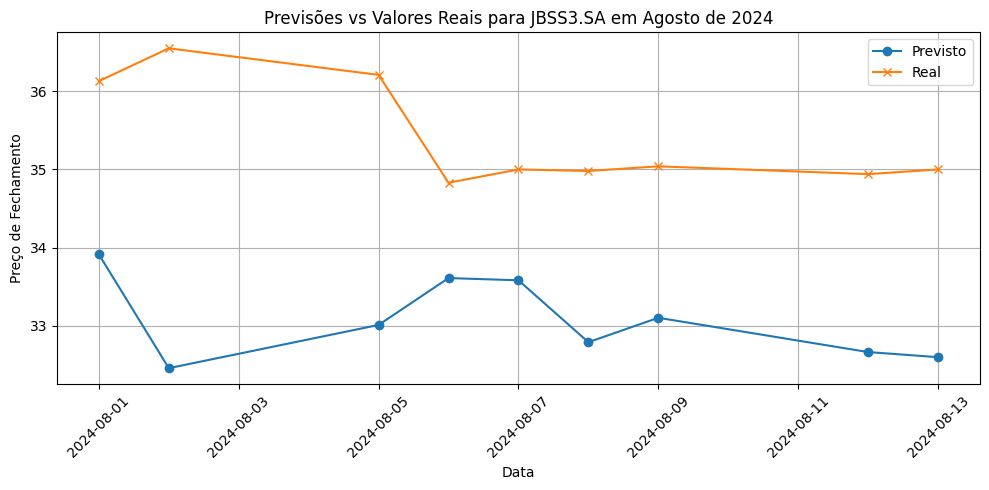


Comparação para MGLU3.SA:
                 Data   Previsto   Real
2024-08-01 2024-08-01  11.246370  13.80
2024-08-02 2024-08-02  11.268970  13.85
2024-08-05 2024-08-05  11.290378  13.18
2024-08-06 2024-08-06  11.262471  13.62
2024-08-07 2024-08-07  11.327971  13.35
2024-08-08 2024-08-08  11.344632  13.47
2024-08-09 2024-08-09  11.290832  13.18
2024-08-12 2024-08-12  11.288724  12.89
2024-08-13 2024-08-13  11.287624  12.16


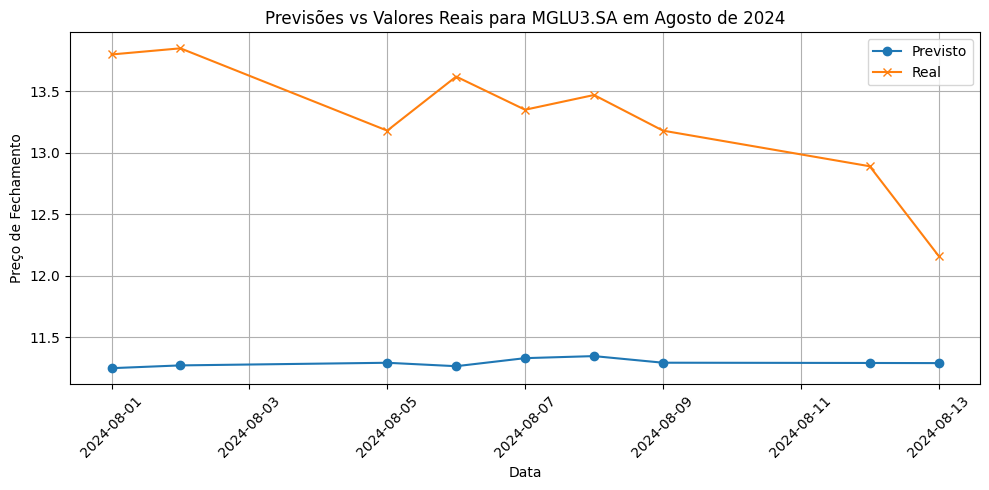


Comparação para BRFS3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  21.259153  25.400000
2024-08-02 2024-08-02  21.018247  26.030001
2024-08-05 2024-08-05  20.879336  25.709999
2024-08-06 2024-08-06  20.851232  25.190001
2024-08-07 2024-08-07  20.849341  25.299999
2024-08-08 2024-08-08  20.797956  25.910000
2024-08-09 2024-08-09  20.859097  26.030001
2024-08-12 2024-08-12  20.697501  25.799999
2024-08-13 2024-08-13  20.307081  26.230000


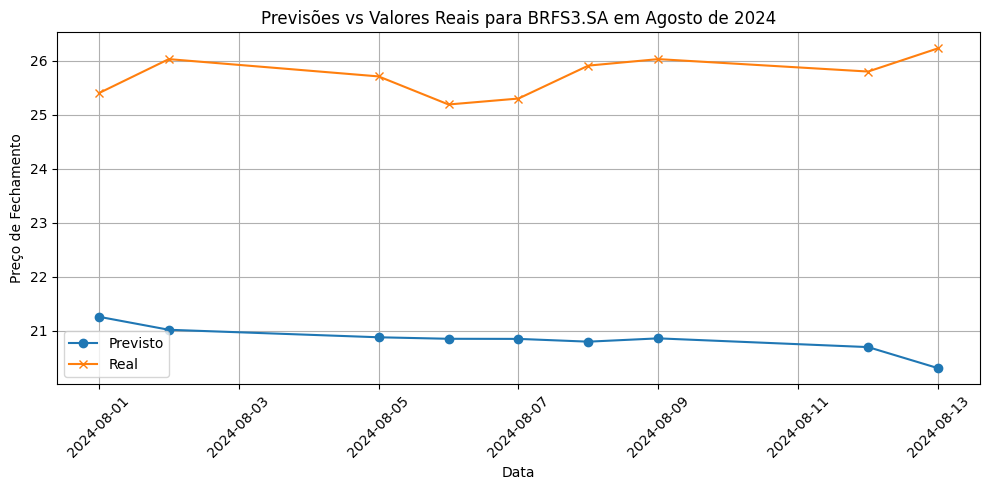


Comparação para SUZB3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  53.237699  55.869999
2024-08-02 2024-08-02  52.774500  56.459999
2024-08-05 2024-08-05  52.856099  56.410000
2024-08-06 2024-08-06  52.544901  56.080002
2024-08-07 2024-08-07  52.611301  55.180000
2024-08-08 2024-08-08  52.262601  55.619999
2024-08-09 2024-08-09  52.398300  56.080002
2024-08-12 2024-08-12  52.363200  55.500000
2024-08-13 2024-08-13  52.754801  55.000000


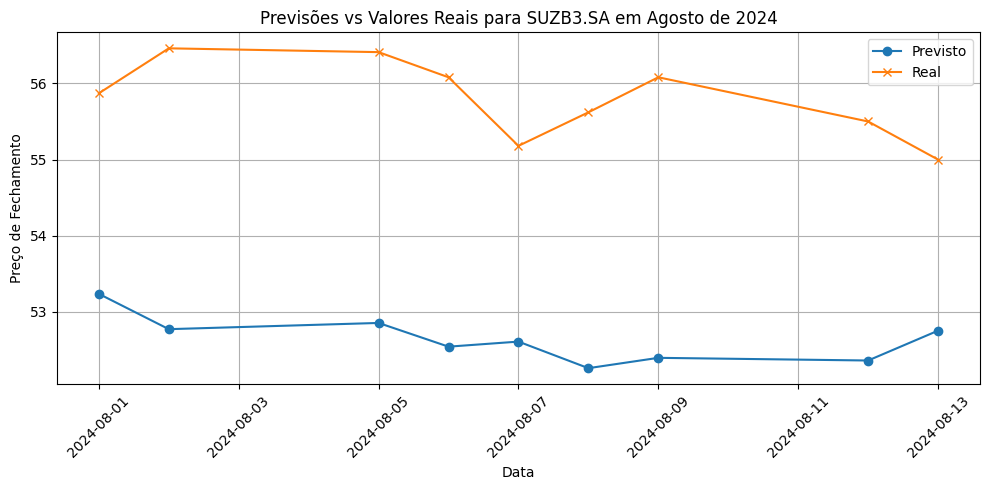


Comparação para ELET3.SA:
                 Data   Previsto       Real
2024-08-01 2024-08-01  37.896201  41.400002
2024-08-02 2024-08-02  38.086200  41.500000
2024-08-05 2024-08-05  38.013358  40.900002
2024-08-06 2024-08-06  38.101300  41.880001
2024-08-07 2024-08-07  38.034400  41.880001
2024-08-08 2024-08-08  38.188700  41.400002
2024-08-09 2024-08-09  38.508454  42.040001
2024-08-12 2024-08-12  38.464879  41.299999
2024-08-13 2024-08-13  38.479664  41.750000


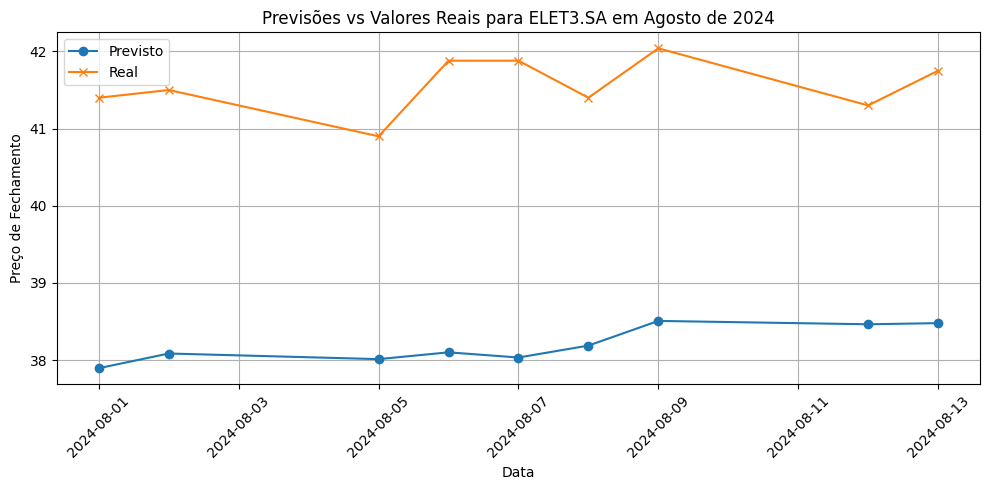

In [217]:
# Comparar previsões com dados reais
for ticker in tickers:
    actual_prices = real_data_prepared[ticker]['Close'].values[:len(future_data[ticker])]
    predicted_prices = future_data[ticker]

    # Garantir que ambos tenham o mesmo comprimento
    min_length = min(len(actual_prices), len(predicted_prices))

    comparison_df = pd.DataFrame({
        'Data': future_dates[:min_length],
        'Previsto': predicted_prices[:min_length],
        'Real': actual_prices[:min_length]
    })
    
    print(f'\nComparação para {ticker}:')
    print(comparison_df)

    # Plotar os resultados
    plt.figure(figsize=(10, 5))
    plt.plot(comparison_df['Data'], comparison_df['Previsto'], label='Previsto', marker='o')
    plt.plot(comparison_df['Data'], comparison_df['Real'], label='Real', marker='x')
    plt.title(f'Previsões vs Valores Reais para {ticker} em Agosto de 2024')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### RandomForestRegressor com GridSearchCV
- **GridSearchCV** é uma ferramenta poderosa para otimizar os hiperparametros de um modelo de aprendizado de maquina


- Define uma lista de acões que serão análisadas

In [218]:
warnings.filterwarnings('ignore')

# Defina os papéis que você deseja analisar
principais_papeis = [
    'PETR4.SA',  # Petrobras
    'VALE3.SA',  # Vale
    'ITUB4.SA',  # Itaú Unibanco
    'BBDC4.SA',  # Bradesco
    'BBAS3.SA',  # Banco do Brasil
    'ABEV3.SA',  # Ambev
    'B3SA3.SA',  # B3
    'WEGE3.SA',  # WEG
    'RENT3.SA',  # Localiza
    'JBSS3.SA',  # JBS
    'MGLU3.SA',  # Magazine Luiza
    'BRFS3.SA',  # BRF
    'SUZB3.SA',  # Suzano
    'GGBR4.SA',  # Gerdau
    'CSNA3.SA',  # CSN
    'LREN3.SA',  # Lojas Renner
    'RAIL3.SA',  # Rumo
    'KLBN11.SA', # Klabin
    'EGIE3.SA',  # Engie Brasil
    'ELET3.SA'   # Eletrobras
]

- Define uma data inicial e limite para o download das informacoes

In [219]:
start_date = '2015-01-01'
end_date = '2024-07-31'

data = {}
for ticker in principais_papeis:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Preparação dos dados
- Calcula o RSI
- Prepara os dados de cada ação

In [220]:
def compute_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [221]:
def prepare_data(df):
    df['Date'] = df.index
    df['Return'] = df['Close'].pct_change()
    df['Moving_Average'] = df['Close'].rolling(window=5).mean()
    df['Volatility'] = df['Return'].rolling(window=5).std()
    df['RSI'] = compute_rsi(df['Close'])
    df['Volume'] = df['Volume']  # Adiciona o volume
    df.dropna(inplace=True)
    return df[['Date', 'Close', 'Moving_Average', 'Volatility', 'RSI', 'Volume']]

- Aplica a função para cada ação

In [223]:
prepared_data = {}
for ticker in principais_papeis:
    prepared_data[ticker] = prepare_data(data[ticker])

### Treinamento do modelo com RandomForestRegressor
- Separação dos dados em treino de 80% e teste de 20%
- Avaliacao do modelo com metricas de MSE e MAE

In [224]:
# Treinamento e teste para previsão
def train_and_predict(df, ticker):
    X = df[['Moving_Average', 'Volatility', 'RSI', 'Volume']]
    y = df['Close']

    # Divisão dos dados
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Parâmetros para GridSearch
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }

    # GridSearch para encontrar os melhores parâmetros
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Modelo otimizado
    model = grid_search.best_estimator_

    # Previsão
    y_pred = model.predict(X_test)

    # Avaliação
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Modelo para {ticker}:')
    print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')

    return mse, mae, model

- Aplica o treinamento para cada ação, mostrando o resultado dos erros

In [225]:

results = {}
for ticker in principais_papeis:
    mse, mae, model = train_and_predict(prepared_data[ticker], ticker)
    results[ticker] = {'MSE': mse, 'MAE': mae, 'Model': model}

Modelo para PETR4.SA:
MSE: 0.37, MAE: 0.41
Modelo para VALE3.SA:
MSE: 1.54, MAE: 0.87
Modelo para ITUB4.SA:
MSE: 0.23, MAE: 0.35
Modelo para BBDC4.SA:
MSE: 0.13, MAE: 0.26
Modelo para BBAS3.SA:
MSE: 0.13, MAE: 0.27


- Analisa os resultados de cada acao e verifica qual teve o melhor indice de erro

In [157]:
# Analisando os resultados para encontrar o melhor papel
best_ticker = min(results, key=lambda x: results[x]['MSE'])
best_mse = results[best_ticker]['MSE']
best_mae = results[best_ticker]['MAE']

print(f'\nMelhor papel baseado no MSE: {best_ticker} com MSE: {best_mse:.2f} e MAE: {best_mae:.2f}')



Melhor papel baseado no MSE: ABEV3.SA com MSE: 0.07 e MAE: 0.19
